# Reinforcement Learning

One of the most exciting and oldest areas of Machine Learning, Reinforcement Learning is concerned with how *agents* behave in an *environment*. Agents receive *rewards* based on their actions and learn to optimize their moves based on these.

Some notable feats of RL are TD-Gammon, an [AI that can learn to play any Atari game](https://arxiv.org/abs/1312.5602) and the Deepmind suite of AlphaGo, AlphaZero and MuZero.

In this chapter we present RL, what problems it can solve and two of the most important techniques in Deep RL; *policy gradients* and *deep Q-networks (DQNs)*, including a discussion of *Markov decision processes (MPDs)*

## Learning to Optimize Rewards

The RL setting is as follows: a software *agent* makes *observations* and takes *actions* within an *environment*, in turn it receives *rewards*. The goal is to learn which actions to take to maximize rewards. Rewards can be positive or negative, and the agent learns by trial and error.

Here are some examples of where RL is can be applied:

1. The agent can be a program controlling a robot, observing the world through sensors and cameras. It's goal may be to reach a destination getting positive rewards when it moves toward it and negative rewards when it wastes time or moves in the wrong directions

2. Agent can be a program playing Pac-Man, its actions are the 9 possible joystick movements, observations are screenshots and rewards game points

3. Agent can be a smart thermostat, getting points when it is close to the target temperature and negative rewards when the humans need to tweak the temperature manually

A slightly different setup can be an agent moving through a maze getting negative reward for each step, sot it better find the ext as quickly as possible. RL can also be applied to self-driving cars, recommender systems, ad placements or controlling where an image classification system should focus its attention.

## Policy Search

The algorithm used by the agents to determine its actions is called its *policy*. A policy can be any algorithm (including a DNN) and does not have to be deterministic (example of a Roomba gathering dust; policy is to move forward with probability *p* or rotate left or right with proba *(1-p)* at random angle $\pm r$. This is an example of a stochastic policy).

One approach to training such a robot would be to try many combinations of the *policy parameters p, r* and pick the best performing one. This is an example of brute-force *policy search*. If the *policy space* is too large (which is generally the case), this is like searching for a needle in a haystack.

Another approach is to use *genetic algorithms*. For example, create 100 random policies, try them out and cut the 80 worst policies. Use the top 20 to produce 4 offsprings each - an offspring is a copy of its parent plus some random variation. The second generation is composed of the surviving policies and its offspring. Iterate through many generations until a good policy is found.

Finally, we can use optimization techniques by evaluating the gradients of the rewards with regard to policy parameters, then tweaking these parameters by following the gradients toward higher rewards. This approach is called *policy gradients* and will be discussed later. 

## Introduction to OpenAI Gym

With RL, the hardest part is often to create a suitable enviroment for your agents. If you want to train a robot to walk in the real world, it can be expensive to build the robot and slow to train it. You may want to create a simulated enviroment for speeding up training. Check out [PyBullet](https://pybullet.org/wordpress/) and [MuJoCo](http://www.mujoco.org/) for 3d environments.


[Gym](https://gym.openai.com/) is a toolkit that provides simulated environments so you can train agents, compare them or develop new RL algorithms.


In [5]:
import numpy as np
import gym
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.animation as animation # To get smooth animations

mpl.rc('animation', html='jshtml')
from jupyterthemes import jtplot as jt
jt.style()

In [2]:
env = gym.make("CartPole-v1")
obs = env.reset()
obs

array([ 0.00366272, -0.02928663, -0.0375483 ,  0.03504036])

The environment above corresponds to a cart holding a pole in a 2D environment that can be moved left or right to balance the pole. To initialize the environment use `reset()` which returns the first observation.

Observations depend on the environment and in ths case we receive a 1D array with four floats containing: horizontal position (`center=0.0`),  velocity (positive means right), angle of the pole (`vertical=0.0`) and angular velocity (positive means clockwise)

In [3]:
def plot_environment(env, figsize=(5,4)):
    plt.figure(figsize=figsize)
    img = env.render(mode="rgb_array")
    plt.imshow(img)
    plt.axis("off")
    return img

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

In [4]:
env.render()

True

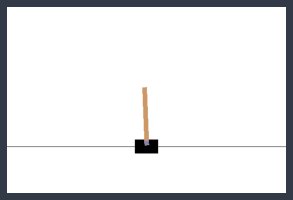

In [5]:
img = env.render(mode="rgb_array")
plot_environment(env)
plt.show()

We can check what are the possible actions

In [6]:
env.action_space

Discrete(2)

This means the possible actions are integers 0 and 1 (left and right). Since the pole is leaning right (`obs[2]>0`), let's accelerate the cart towards the right

In [7]:
action = 1
obs, reward, done, info = env.step(action)

print(f"Obs {obs}")
print(f"Reward {reward}")
print(f"Done {done}")
print(f"Info {info}")


Obs [ 0.00307699  0.16635309 -0.03684749 -0.26924899]
Reward 1.0
Done False
Info {}


By taking a `step()` we move the cart and get four values returned

- *obs*
> The new observation
- *reward*
> In this environment, we get a reward of 1 at every step, the goal is to keep the episode running as long as possible
- *done*
> `True` when the episode is over. Happens when the pole tilts too much, goes off the screen, or after 200 steps (victory!)
- *info*
> Extra information useful for debugging or training


The first policy we'll implement is a simple one: accelerate left when the pole is leaning left and accelerate right when the pole is leaning right. We'll run it over 500 episodes and see the average rewards

In [8]:
def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

totals = []
for episode in range(500):
    episode_rewards = 0
    obs = env.reset()
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, info = env.step(action)
        episode_rewards += reward
        if done:
            break
    totals.append(episode_rewards)

In [9]:
import numpy as np

np.mean(totals), np.std(totals), np.min(totals), np.max(totals)

(42.304, 8.278380517951565, 24.0, 64.0)

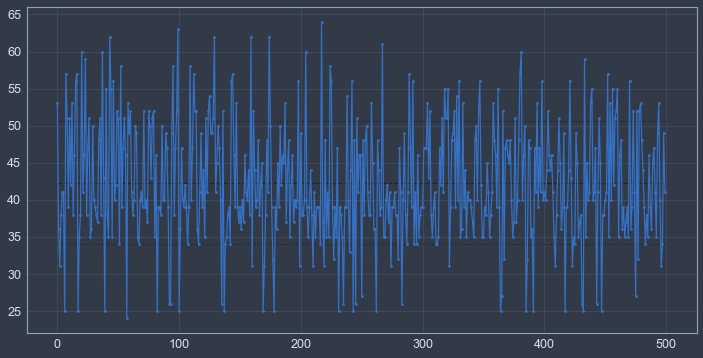

In [10]:
x = range(len(totals))
plt.figure(figsize=(12,6))
plt.plot(x, totals, '.-')
plt.hlines(np.mean(totals), 0, 500, 'k', 'dashed')
plt.hlines(np.mean(totals) + np.std(totals), 0, 500, 'k', 'dotted')
plt.hlines(np.mean(totals) - np.std(totals), 0, 500, 'k', 'dotted')
plt.show()

In [11]:
env.seed(42)

frames = []
obs = env.reset()
for step in range(200):
    img = env.render(mode="rgb_array")
    frames.append(img)
    action = basic_policy(obs)
    obs, reward, done, info = env.step(action)
    if done:
        break
plot_animation(frames)

## Neural Network Policies

We'll create a NN policy that will take an observation as input and output the action to be execute. More precisely, it will estimate a probability for each action, then we select an action randomly according to the estimated probabilities. 

This approach allows the agent to balance between *exploring* new action and *exploting* the actions that are known to work well.

Note that in this environment, past actions and observations can be safely ignored since each observation contains the environment's full state. If there were hidden states, you may need to consider past actions and observations as well. For example if the environment only revealed the position of the cart but not its velocity, you would have to not only consider the current observation but also the previous observation to estimate the current velocity.

In [11]:
import tensorflow as tf
from tensorflow import keras

In [12]:
n_inputs = 4 # env.observation_space.shape[0]

In [13]:
model = keras.models.Sequential([
  keras.layers.Dense(5, activation="elu", input_shape=[n_inputs]),
  keras.layers.Dense(1, activation="sigmoid")
])

In [14]:
def render_policy_net(model, n_max_steps=200, seed=42):
    frames = []
    env = gym.make("CartPole-v1")
    env.seed(seed)
    np.random.seed(seed)
    obs = env.reset()
    for step in range(n_max_steps):
        frames.append(env.render(mode="rgb_array"))
        left_proba = model.predict(obs.reshape(1, -1))
        action = int(np.random.rand() > left_proba)
        obs, reward, done, info = env.step(action)
        if done:
            break
    env.close()
    return frames

In [16]:
frames = render_policy_net(model)
plot_animation(frames)

We only use a small networks as the problem is very simple. The next question to tackle is: how do we train this network?

## Evaluating Actions: The Credit Assignment Problem

One may think that if we knew the best course of  action at each step, we could train the NN as usual, minimizing cross entropy between the estimated probability distribution and the target distribution. 

In RL however, the only guidance we have are the rewards, and rewards are typically sparse and delayed. 

Suppose for example the agent is able to balance the pole for 100 steps. How can it know which of the 100 actions it took were good and which were bad. It only knows that the pole fell after the last action, but surely this last action is not entirely responsible. 

This is called the **credit assignment problem**: when the agent getas a reward it is hard to know which actions should get credit (or blame) for it. 

One strategy to tackle this issue, is to evaluate an action based on the sum of rewards that come after it, usually applying a discount factor $\gamma$. This sum of discounted rewards is called the action's *return*

Consider the example where the agent moves right 3 times in a row and gets +10 reward after the first step, 0 after the second step and -50 after the third. With a discount of $\gamma=0.8$ the first action has a reward of $10 + \gamma\times0 + \gamma^2 \times (-50)=-22$

With $\gamma$ close to zero, future rewards don't count as much compared to immediate rewards. Conversely, with a discount factor of 1 then rewards in the future will count as much as immediate rewards.

In CartPole, actions have fairly short-term effects so a $\gamma=0.95$ seems reasonable.

Naturally, good actions may be followed by several ba actions, resulting in a good action getting a low return. However, given enough samples, on average good actions will have higher return than bade ones.

We want to estimate how much better or worse an action is, compared to the other possible actions, on average. This is called *action advantage*. First, we need to normalize the action returns (subtract mean, divided by std), then we can reasonably assume that actions with a negative advantage were bad while actions with a positive advantage were good. 

Now we can evaluate actions, let's train our agent using policy gradients

## Policy Gradients

These algorithms optimize the parameters of a policy by following gradients towards higher rewards. A popular class of algorithms called [REINFORCE algorithms](https://people.cs.umass.edu/~barto/courses/cs687/williams92simple.pdf) was introduced in 1992. The following is a variant
1. Let the NN policy play the game several times, computing gradients that make the chosen action more likely at each step. Do not apply them yet.
2. Once you run the episode several times, calculate each action's advantage (using steps above)
3. If an action's advantage is positive, it was probably a good action, and we want to apply the gradients computed earlier to make this more likely. Else, it was probably a bad action and we apply the opposite gradients to make this action less likely. The solution is to simply multiply each gradient vector by the corresponding action advantage
4. Compute mean of resulting gradient vectors and use it to perform Gradient Descent

We'll implement this algorithm with Keras. We start by defining a function that plays one step. We initially assume that whatever action it takes is the correct action to compute the loss and gradients

In [15]:
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])  # batch with single instance
        action = (tf.random.uniform([1, 1]) > left_proba)  # False with p=left_proba, True with p=1-left_proba
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)  # Probability of going left
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))
    grads = tape.gradient(loss, model.trainable_variables)  # calc gradients
    obs, reward, done, info = env.step(int(action[0, 0].numpy()))  # Play the action
    return obs, reward, done, grads

The next function will use `play_one_step` to play multiple episoeds, returning all rewards and gradients for each episode and step

In [16]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards, all_grads = [], []
    for episode in range(n_episodes):
        current_rewards, current_grads = [], []
        obs = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, grads = play_one_step(env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

Now we have a list of rewards and a list of gradients. We will use this to play the game multiple times, look back at all rewards, discount them and normalize them. Let's define two functions: the first to compute the sum of future rewards discounted at each step and the second to normalize the discounted rewards

In [17]:
def discount_rewards(rewards, discount_factor):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_factor
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_factor):
    all_discounted_rewards = [discount_rewards(rewards, discount_factor) 
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

In [18]:
test_rewards = [10, 0, -50]
discount_rewards(test_rewards, 0.8)

array([-22, -40, -50])

In [19]:
discount_and_normalize_rewards([test_rewards, [10, 20]], 0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

Define some more parameters, optimizer, loss and the training loop

In [20]:
n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_factor = 0.95

optimizer = keras.optimizers.Adam(lr=0.01)
loss_fn = keras.losses.binary_crossentropy

In [23]:
from tqdm import  tqdm

for iteration in tqdm(range(n_iterations), ascii=True, desc="iteration #"):
    all_rewards, all_grads = play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn)  # play the game 10 times
    all_final_rewards = discount_and_normalize_rewards(all_rewards, discount_factor)
    
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
             for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

iteration #: 100%|###################################################################| 150/150 [09:52<00:00,  3.95s/it]


In [24]:
model.save('saved_models/18_reinforcement_learning/cart_pole_v1')

INFO:tensorflow:Assets written to: saved_models/19_reinforcement_learning/cart_pole_v1\assets


This trained agent should successfully learn to balance the pole.

In [21]:
model = keras.models.load_model('saved_models/18_reinforcement_learning/cart_pole_v1')

In [22]:
frames = render_policy_net(model)
plot_animation(frames)

### Tip
*Researchers try to find algorithms that work well even when the agent initially knows nothing about the environment. However, unless you are writing a paper, you should not hesitate to inject prior knowledge into the agent, as it will speed up training dramatically. For example, since you know that the pole should be as vertical as possible, you could add negative rewards proportional to the pole’s angle. This will make the rewards much less sparse and speed up training. Also, if you already have a reasonably good policy (e.g., hardcoded), you may want to train the neural network to imitate it before using policy gradients to improve it.*

While this algorithm works well for CartPole, it does not scale well to more larger, complex tasks. It is a *sample inneficient* algorithm, meaning it needs to explore the game for a very long time before making significant progress. It serves, however, as the foundation for more powerful actor-critic algorithms such as *Actor-Critic* algorithms

## Markov Decision Processes

Memoryless process are process where the evolution from a state $s$ to the next state $s'$ only depends on $(s, s')$ and no other previous states. Such a process can also be called a *Markovian process*. They are typically refered to as *Markov Chains* when transitions from a state to the next are given by probability (i.e. it is a stochastic finite automaton)

A *Markov Decision Process* is similar to a Markov chain, but with a twist: at each step, the agent can choose one of many actions and the transition probabilities between states depends on the chosen action (seems Bayesian to me). Some state transitions may return a reward (postive or negative) and the agent's goal is to find a policy that will maximize reward over time.

See figure 18-8 (pg 626) for a description.

[Richard Bellman](https://scholar.google.com/scholar?q=a+markovian+decision+process+author%3Abellman) found a way to estimate the *optimal state value* of any state $s$, noted $V^*(s)$ , which is the sum of all discounted future rewards the agent can expect on average after it reaches a state $s$, assuming it acts optimally. If it does act optimally, then the *Bellman Optimality Equation* applies

$$ V^*(s) = \max_\limits{a}\sum_{s'}T(s, a, s') [R(s, a, s') + \gamma\cdot V^*(s')] \ \ \  \forall s$$

- $T(s, a, s')$ is the transition probability from state $s$ to $s'$, given that the agent chose action $a$
- $R(s, a, s')$ is the reward that the agent gets when it goes from state $s$ to state $s'$
- $\gamma$ is the discount factor

This equation tells us that the optimal value of the current state is equal to the reward it will get on average after taking one optimal action, plus the expected optimal value of all prossible next states that this action can lead to

The algorithm that optimizes this equatin can precisely estimate the optimal state value of every possible state: you first initialize all state value estimates to zero, then iteratively update them using the *Value iteration* algorithm

$$ V_{k+1}(s) \leftarrow \max_\limits{a}\sum_{s'}T(s, a, s') [R(s, a, s') + \gamma\cdot V_k(s')] \ \ \  \forall s $$

$V_k(s)$ is the estimated value of state $s$ after $k$ iterations. Given enough time, these estimates are guaranteed to converge to the optimal state values corresponding to the optimal policy.

Knowing the optimal state values is useful and can help us evaluate policies, but it does not give us the optimal policy. To estimate the optimal *state-action values*, generally called *Q-values* (quality values), we use the *Q-Value iteration* algorithm.

The optimal Q-Value of the state-action pair $(s, a)$, denoted $Q^*(s,a)$, is the sum of discounted future rewards the agent can expect on average after it reaches the state $s$ and chooses action $a$, but before it sees the outcome of this action, assuming it acts optimally after that action.


Again, we initialize all Q-Value estimates to zero then update them with the Q-value iteration algorithm

$$ Q_{k+1}(s,a) \leftarrow \sum_{s'}T(s, a, s') [R(s, a, s') + \gamma\cdot\max_\limits{a'}Q_k(s',a')] \ \ \ \forall \ (s,a)$$

With the optimal Q-values in hand, definining the optimal policy $\pi^*(s)$ is trivial: in state $s$ the agent should choose the action with the highest Q-Value for that state: $\pi^*(s) = \arg\max_\limits{a}Q^*(s,a)$

The example code below will simulate the MDP described in figure 18-8

In [27]:
transition_probas = [ # shape=[s, a, s']
        [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
        [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
        [None, [0.8, 0.1, 0.1], None]]

rewards = [ # shape=[s, a, s']
        [[+10, 0, 0], [0, 0, 0], [0, 0, 0]],
        [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
        [[0, 0, 0], [+40, 0, 0], [0, 0, 0]]]

possible_actions = [[0, 1, 2], [0, 2], [1]]

Initialize all Q-values to 0, except for impossible actions which we will assign $-\inf$

In [35]:
Q_values = np.full((3,3), -np.inf)  # impossible actions
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0   # possible actions

In [36]:
Q_values

array([[  0.,   0.,   0.],
       [  0., -inf,   0.],
       [-inf,   0., -inf]])

Next we run the Q-Value iteration algorithm, applying the equation to all Q-Values for every state and possible action

In [37]:
gamma = 0.90

for iteration in range(50):
    Q_prev = Q_values.copy()
    Q_hist.append(Q_prev)
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum([
                transition_probas[s][a][sp] * (rewards[s][a][sp] + gamma*np.max(Q_prev[sp]))
                for sp in range(3)])

The resulting values are

This means that in state $s_0$, choosing action $a_1$ gives an expected sum of discounted rewards of ~17.0. We can also look at the action that has highest Q-Value for each state

In [48]:
np.argmax(Q_values, axis=1)

array([0, 0, 1], dtype=int64)

And now we have the optimal policy for this MDP. Using $\gamma=0.9$
- In $s_0$, choose $a_0$
- In $s_1$, choose $a_0$
- In $s_2$, choose $a_1$

Changing the value fo $\gamma$ changes the optimal policy. Try for example $\gamma=0.95$. This will give more value to future rewards.

### Temporal Difference Learning

RL problems with discrete actions can be modeled as MDPs, however the starting point is usually unknown: the agent does not know the transition probabilities and it does not know what the rewards are either. It must experience each state and transition at least once to knoe the rewards and must experience them multiple times if it is to have a reasonable estimate of transition probabilities.

*Temporal Difference Learning* (TD learning) is quite similar to the value iteration algorithm, but it also takes into account the fact that the agent has partial knowledge of the MDP.

We initially assume the agent only knows all possible states and actions. The agent uses an *exploration policy* - e.g. a purely random policy - to explore the MDP and as it progresses the TD learning algorithm updates the estimates of the state values based on the transitions and rewards that are actually observed.

$$ V_{k+1}(s) \leftarrow (1-a)V_k(s) + \alpha(r + \gamma\cdot V_k(s')) $$
Or equivalently
$$ V_{k+1}(s) \leftarrow V_k(s) + \alpha\cdot\delta_k(s,r,s') \ \text{  with  } \ \delta_k(s,a,s') = r+\gamma\cdot V_k(s') - V_k(s)$$

- $\alpha$ is the learning rate 
- $r+\gamma\cdot V_k(s')$ is called the *TD target*
- $delta_k(s,r,s')$ is called the *TD error*

For each state $s$, this algorithm simply keeps track of a running average of the immediate rewards the agent gets upon leaving that state, plus the rewards it expects to get later (assuming it acts optimally)

A concise way to writh this equation is to use the notation $a \xleftarrow[\alpha]{} b$ which means $a_{k+1} \leftarrow (1-\alpha)\cdot a_k + \alpha\cdot b_k$.

Thus, the equation becomes $V(s) \xleftarrow[\alpha]{} r + \gamma\cdot V(s')$

TD learning is similar to Stochastic Gradient Descent, in particular the fact that it handles one sample at a time. Moereover, just like SGD, it can only truly converge if you gradiually reduce the learning rate (otherwise it will just bounce around the optimum Q-values)

### Q-learning